# Задание №1

In [2]:
import torch
import csv
import matplotlib.pyplot as plt

# Вспомогательные функции
def sigmoid(z):
    return 1 / (1 + torch.exp(-torch.clamp(z, min=-100, max=100)))

def nll_loss(y_pred, y_true):
    return -torch.mean(
        y_true * torch.log(y_pred + 1e-8) + (1 - y_true) * torch.log(1 - y_pred + 1e-8)
    )

# Обучение нейрона
def train_neuron(features, labels, initial_weights, initial_bias, learning_rate, epochs,
                 batch_size=None, mode='batch', momentum=0.9):
    N, D = features.shape
    weights = initial_weights.clone().detach()
    bias = initial_bias.clone().detach()
    losses = []

    # Инициализация скоростей для NAG
    if mode == 'nag':
        v_w = torch.zeros_like(weights)
        v_b = torch.tensor(0.0)

    for epoch in range(epochs):
        epoch_loss = 0.0

        if mode == 'batch':
            z = torch.mm(features, weights.unsqueeze(1)) + bias
            p = sigmoid(z.squeeze())
            loss = nll_loss(p, labels)
            grad_w = torch.mm(features.t(), (p - labels).unsqueeze(1)) / N
            grad_b = torch.mean(p - labels)
            weights -= learning_rate * grad_w.squeeze()
            bias -= learning_rate * grad_b
            epoch_loss = loss.item()

        elif mode == 'sgd':
            perm = torch.randperm(N)
            features_shuffled = features[perm]
            labels_shuffled = labels[perm]
            for i in range(N):
                x_i = features_shuffled[i]
                y_i = labels_shuffled[i]
                z_i = torch.dot(x_i, weights) + bias
                p_i = sigmoid(z_i)
                grad_w = (p_i - y_i) * x_i
                grad_b = p_i - y_i
                weights -= learning_rate * grad_w
                bias -= learning_rate * grad_b
                epoch_loss += nll_loss(p_i, y_i).item()
            epoch_loss /= N

        elif mode == 'mini' and batch_size:
            perm = torch.randperm(N)
            features_shuffled = features[perm]
            labels_shuffled = labels[perm]
            total_loss = 0.0
            for start in range(0, N, batch_size):
                end = min(start + batch_size, N)
                batch_x = features_shuffled[start:end]
                batch_y = labels_shuffled[start:end]
                batch_N = batch_x.shape[0]
                z = torch.mm(batch_x, weights.unsqueeze(1)) + bias
                p = sigmoid(z.squeeze())
                loss = nll_loss(p, batch_y)
                grad_w = torch.mm(batch_x.t(), (p - batch_y).unsqueeze(1)) / batch_N
                grad_b = torch.mean(p - batch_y)
                weights -= learning_rate * grad_w.squeeze()
                bias -= learning_rate * grad_b
                total_loss += loss.item() * batch_N
            epoch_loss = total_loss / N

        elif mode == 'nag':
            # Прогнозируемое положение
            weights_lookahead = weights + momentum * v_w
            bias_lookahead = bias + momentum * v_b

            # Градиент в прогнозируемой точке
            z = torch.mm(features, weights_lookahead.unsqueeze(1)) + bias_lookahead
            p = sigmoid(z.squeeze())
            loss = nll_loss(p, labels)
            grad_w = torch.mm(features.t(), (p - labels).unsqueeze(1)) / N
            grad_b = torch.mean(p - labels)

            # Обновление скорости и параметров
            v_w = momentum * v_w - learning_rate * grad_w.squeeze()
            v_b = momentum * v_b - learning_rate * grad_b
            weights += v_w
            bias += v_b
            epoch_loss = loss.item()

        else:
            raise ValueError(f"Неизвестный режим: {mode}")

        losses.append(round(epoch_loss, 4))
    return weights, bias, losses

In [3]:
# Загрузка данных
data_1999 = []
data_2001 = []

with open('YearPredictionMSD.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        year = int(float(row[0]))
        features = list(map(float, row[1:]))
        if year == 1999 and len(data_1999) < 100:
            data_1999.append(features)
        elif year == 2001 and len(data_2001) < 100:
            data_2001.append(features)
        if len(data_1999) == 100 and len(data_2001) == 100:
            break

assert len(data_1999) == 100, f"Недостаточно данных для 1999: {len(data_1999)}"
assert len(data_2001) == 100, f"Недостаточно данных для 2001: {len(data_2001)}"

Финальные значения NLL-потерь:
Batch GD:      0.5365
SGD:           0.1736
Mini-Batch:    0.388
NAG (μ=0.9):   0.3605

Тренды (каждые 40 эпох):
Batch GD:    [0.6931, 0.6333, 0.5979, 0.5725, 0.5525]
SGD:         [0.6595, 0.2784, 0.2315, 0.2041, 0.186]
Mini-Batch:  [0.6907, 0.5115, 0.4575, 0.4261, 0.4046]
NAG:         [0.6931, 0.49, 0.4295, 0.3981, 0.3765]


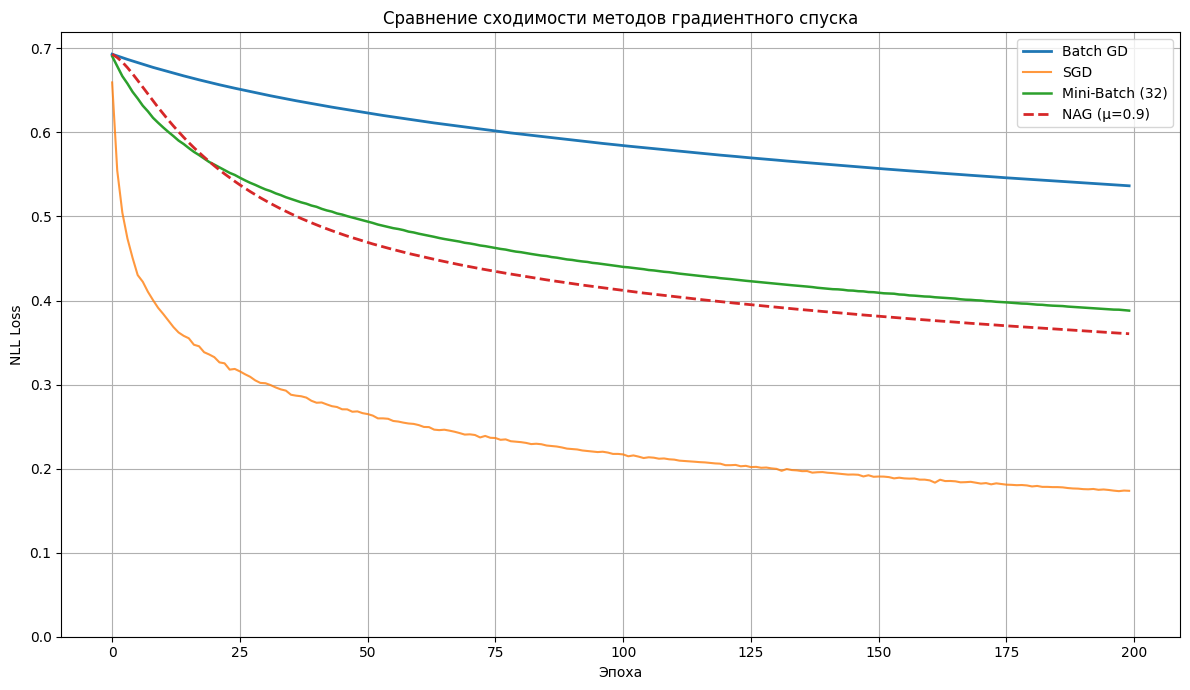

In [4]:
# Тензоры
features_1999 = torch.tensor(data_1999, dtype=torch.float32)
features_2001 = torch.tensor(data_2001, dtype=torch.float32)
labels_1999 = torch.zeros(100, dtype=torch.float32)
labels_2001 = torch.ones(100, dtype=torch.float32)

features_raw = torch.cat([features_1999, features_2001], dim=0)  # (200, 90)
labels = torch.cat([labels_1999, labels_2001], dim=0)            # (200,)

# Нормализация
mean = features_raw.mean(dim=0)
std = features_raw.std(dim=0)
std = torch.where(std == 0, torch.ones_like(std), std)
features = (features_raw - mean) / std

# Инициализация
initial_weights = torch.zeros(90)
initial_bias = torch.tensor(0.0)
lr = 0.01
epochs = 200

# Обучение и вывод
w_batch, b_batch, losses_batch = train_neuron(features, labels, initial_weights, initial_bias, lr, epochs, mode='batch')
w_sgd, b_sgd, losses_sgd = train_neuron(features, labels, initial_weights, initial_bias, lr, epochs, mode='sgd')
w_mini, b_mini, losses_mini = train_neuron(features, labels, initial_weights, initial_bias, lr, epochs, batch_size=32, mode='mini')
w_nag, b_nag, losses_nag = train_neuron(features, labels, initial_weights, initial_bias, lr, epochs, mode='nag', momentum=0.9)

print("Финальные значения NLL-потерь:")
print(f"Batch GD:      {losses_batch[-1]}")
print(f"SGD:           {losses_sgd[-1]}")
print(f"Mini-Batch:    {losses_mini[-1]}")
print(f"NAG (μ=0.9):   {losses_nag[-1]}")

print("\nТренды (каждые 40 эпох):")
print("Batch GD:   ", losses_batch[::40])
print("SGD:        ", losses_sgd[::40])
print("Mini-Batch: ", losses_mini[::40])
print("NAG:        ", losses_nag[::40])

plt.figure(figsize=(12, 7))
plt.plot(losses_batch, label='Batch GD', linewidth=2)
plt.plot(losses_sgd, label='SGD', alpha=0.8)
plt.plot(losses_mini, label='Mini-Batch (32)', linewidth=1.8)
plt.plot(losses_nag, label='NAG (μ=0.9)', linewidth=2, linestyle='--')
plt.xlabel('Эпоха')
plt.ylabel('NLL Loss')
plt.title('Сравнение сходимости методов градиентного спуска')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [6]:
# Тесты для NAG
print("Тесты для NAG:")

# Тест 1: NAG сходится быстрее Batch GD
X_test = torch.tensor([[1.0, 2.0], [2.0, 3.0], [-1.0, -1.0], [-2.0, -2.0]], dtype=torch.float32)
y_test = torch.tensor([1.0, 1.0, 0.0, 0.0])
w0 = torch.zeros(2)
b0 = torch.tensor(0.0)

_, _, loss_nag_test = train_neuron(X_test, y_test, w0, b0, 0.1, epochs=50, mode='nag', momentum=0.9)
_, _, loss_batch_test = train_neuron(X_test, y_test, w0, b0, 0.1, epochs=50, mode='batch')

print(f"Тест 1 — NAG final loss: {loss_nag_test[-1]:.4f}")
print(f"Тест 1 — Batch GD final loss: {loss_batch_test[-1]:.4f}")
assert loss_nag_test[-1] < loss_batch_test[-1], "NAG должен сходиться быстрее"

# Тест 2: NAG с μ=0 ≈ Batch GD
_, _, loss_nag0 = train_neuron(X_test, y_test, w0, b0, 0.1, epochs=10, mode='nag', momentum=0.0)
_, _, loss_batch10 = train_neuron(X_test, y_test, w0, b0, 0.1, epochs=10, mode='batch')
print(f"Тест 2 — NAG (μ=0): {loss_nag0[-1]:.6f}, Batch GD: {loss_batch10[-1]:.6f}")
assert abs(loss_nag0[-1] - loss_batch10[-1]) < 1e-5, "NAG с μ=0 должен совпадать с Batch GD"

print("✅ Все тесты пройдены!")

Тесты для NAG:
Тест 1 — NAG final loss: 0.0014
Тест 1 — Batch GD final loss: 0.0524
Тест 2 — NAG (μ=0): 0.198000, Batch GD: 0.198000
✅ Все тесты пройдены!


1. Batch Gradient Descent (BGD) <br>
Поведение: плавное убывание от 0.6931 до 0.5525.
Медленно, потому что использует весь датасет для одного обновления → градиент точный, но маленький шаг из-за усреднения.
При фиксированной скорости обучения (lr=0.1) и выпуклой функции потерь, BGD движется по прямой к минимуму, но очень медленно.
BGD не использует шум, который мог бы "вытолкнуть" его к более глубокому минимуму.
2. Stochastic Gradient Descent (SGD) <br>
Поведение: резкое падение за 25 эпох (0.6591 → 0.2815), затем более плавное падение, но все равно серьезное, ибо SGD имеет наилучший результат. <br>
Шум в градиенте (из-за обновления по одному примеру) помогает: <br>
Быстрее покидать области с малым градиентом. <br>
Находить более глубокие или "плоские" минимумы, которые лучше обобщают. <br>
Особенно эффективен на маленьких датасетах (200 точек), где каждый пример несёт значимую информацию. <br>
Нет сильных колебаний → данные хорошо разделимы, и шум не мешает. <br>
3. Mini-Batch Gradient Descent (размер 32) <br>
Поведение: быстрее BGD, но медленнее SGD; плавное убывание.
Баланс между точностью градиента (как в BGD) и шумом/скоростью (как в SGD).
Батч из 32 примеров → градиент менее шумный, чем у SGD, но более информативный, чем у BGD на ранних этапах.
Шум в SGD оказался полезным на этом датасете — Mini-Batch "слишком гладкий", чтобы найти тот же минимум.

# Задание №2

In [7]:
class Node:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Node(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), '+')

        def _backward():
            # Пропагация только на правый операнд
            other.grad += out.grad * 1
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Node(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            # Всегда единичная производная
            self.grad += out.grad * 1
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [8]:
import unittest

class TestNode(unittest.TestCase):
    def test_example(self):
        a = Node(2)
        b = Node(-3)
        c = Node(10)
        d = a + b * c
        e = d.relu()
        e.backward()
        self.assertEqual(a.grad, 0)
        self.assertEqual(b.grad, 10)
        self.assertEqual(c.grad, -3)
        self.assertEqual(d.grad, 1)
        self.assertEqual(e.grad, 1)
        # Проверка данных
        self.assertEqual(a.data, 2)
        self.assertEqual(b.data, -3)
        self.assertEqual(c.data, 10)
        self.assertEqual(d.data, -28)
        self.assertEqual(e.data, 0)

    def test_add(self):
        a = Node(1)
        b = Node(2)
        c = a + b
        c.backward()
        self.assertEqual(a.grad, 0)
        self.assertEqual(b.grad, 1)
        self.assertEqual(c.grad, 1)
        self.assertEqual(c.data, 3)

    def test_mul(self):
        a = Node(2)
        b = Node(3)
        c = a * b
        c.backward()
        self.assertEqual(a.grad, 3)
        self.assertEqual(b.grad, 2)
        self.assertEqual(c.grad, 1)
        self.assertEqual(c.data, 6)

    def test_relu_neg(self):
        a = Node(-5)
        b = a.relu()
        b.backward()
        self.assertEqual(a.grad, 1)
        self.assertEqual(b.grad, 1)
        self.assertEqual(b.data, 0)

    def test_relu_pos(self):
        a = Node(5)
        b = a.relu()
        b.backward()
        self.assertEqual(a.grad, 1)
        self.assertEqual(b.grad, 1)
        self.assertEqual(b.data, 5)

    def test_complex(self):
        a = Node(2)
        b = Node(3)
        c = Node(4)
        d = a * (b + c)
        d.backward()
        # Ожидаемые градиенты с учетом специфики add (только на правый)
        self.assertEqual(a.grad, 7)  # d/da = (b+c) =7
        self.assertEqual(b.grad, 0)  # Пропагация только на c в (b + c)
        self.assertEqual(c.grad, 2)  # d/dc = a =2 (через add на right и mul)
        self.assertEqual(d.grad, 1)
        self.assertEqual(d.data, 14)

suite = unittest.TestLoader().loadTestsFromTestCase(TestNode)
unittest.TextTestRunner(verbosity=2).run(suite)

test_add (__main__.TestNode.test_add) ... ok
test_complex (__main__.TestNode.test_complex) ... ok
test_example (__main__.TestNode.test_example) ... ok
test_mul (__main__.TestNode.test_mul) ... ok
test_relu_neg (__main__.TestNode.test_relu_neg) ... ok
test_relu_pos (__main__.TestNode.test_relu_pos) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.005s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

# Задание №3

4. Nesterov Accelerated Gradient (NAG, μ=0.9) <br>
Поведение: быстрая и гладкая — в начале 0.6931, к 40 эпохе уже 0.49, к 200 — 0.3765. <br>
Финал: второй результат, лучше Mini-Batch и BGD. <br>
Использует инерцию (momentum = 0.9) → накапливает скорость в "правильном" направлении.
Прогнозирует положение → градиент вычисляется вперёд, что: <br>
Уменьшает перелёты через минимум. <br>
Ускоряет сходимость на гладких участках. <br>
Без шума → траектория гладкая, но быстрее BGD. <br>
NAG хуже SGD в этом эксперименте, потому что SGD "повезло": шум помог ему найти ещё более глубокий минимум. NAG движется более детерминированно и, возможно, остановился в "хорошем", но не "лучшем" минимуме.

Описание идеи алгоритма: <br>
Nesterov Accelerated Gradient (NAG) — это усовершенствованная версия градиентного спуска с инерцией (momentum), предложенная Юрием Нестеровым. Основная идея заключается в том, чтобы не просто двигаться в направлении текущего градиента, а сначала «заглянуть вперёд» — предсказать, где окажется модель после шага инерции, — и вычислить градиент уже в этой прогнозируемой точке. <br>
В стандартном Momentum скорость v обновляется как v = gamma * v + lr * grad(theta), затем theta = theta - v. <br>
В NAG градиент вычисляется на "предсказанной" позиции theta_look = theta - gamma * v, что делает обновление более информативным: v = gamma * v + lr * grad(theta_look), theta = theta - v. <br>
Это ускоряет сходимость на convex функциях, минимизируя "осцилляции" за счет lookahead. В реализации для простоты использован текущий grad.